In [2]:
rm(list=ls())
libraries = c("dplyr","magrittr","tidyr","reshape2","ggplot2","ggpubr","hrbrthemes","extrafont","openxlsx","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","readr","stats","boot","pracma","stringr","mixdist","corpcor","rstan","bayesplot")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

theme_set(theme_bw())
setwd("../waning_ve_estimation_multivariant")

In [3]:
ncov_vax <- read_csv("data/vax_rollout_simulation.csv") 
ncov_vax%>%head(5);ncov_vax%>%tail(5)

Parsed with column specification:
cols(
  week = col_double(),
  vaccine = col_double(),
  cumulative = col_double()
)



week,vaccine,cumulative
<dbl>,<dbl>,<dbl>
1,14532,358776
2,14783,373559
3,17431,390990
4,31970,422960
5,97021,519981


week,vaccine,cumulative
<dbl>,<dbl>,<dbl>
69,12448,12586925
70,11167,12598092
71,13168,12611260
72,9513,12620773
73,13262,12634035


### Scenario 1

In [4]:
### ve basic function
basicfn <- function(p,k,t){
    fn <-  p*(1/(exp(k*(t-1)) + 1))
    return(fn)
}

ve_A <- function(t){
    fn <- basicfn(p=0.95*2,k=0.01,t) #0.002
    return(fn)
}
ve_B <- function(t){
    fn <- basicfn(p=0.90*2,k=0.02,t) #0.005
    return(fn)
}
ve_C <- function(t){
    fn <- basicfn(p=0.90*2,k=0.01,t) #0.012
    return(fn)
}
ve_D <- function(t){
    fn <- basicfn(p=0.80*2,k=0.03,t)
    return(fn)
}

In [5]:
source("src/R/Simulation.R") # load functions

### simulation code

### stan code

In [48]:
source("src/stan/Model_Simulation_param.stan") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [8]:
It <- case_df_plot %>% filter(Type=="Unvaccinated") 
Jt <- case_df_plot %>% filter(Type=="Vaccinated") 

In [ ]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 15000000
num_data = T+l+delay
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
v_cumu = ncov_vax$cumulative[1:(T+l+delay)]/N
unv_cumu=1-ncov_vax$cumulative[1:(T+l+delay)]/N
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, v_cumu=v_cumu, unv_cumu=unv_cumu, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","k","p","ii","jj")
# eps: overall effect over time, ve: direct effect over time


nuts_fit1 = stan(model_code=Model,data=data,pars=parameters,iter=3500,thin=1,warmup=500,chain=2)

In [263]:
nrow(A)

[1] 73

In [51]:
nuts_fit1

Inference for Stan model: 6785490460c181c03266e1ee708757dc.
2 chains, each with iter=3500; warmup=500; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

              mean se_mean     sd     2.5%      25%      50%      75%    97.5%
ve_o[1]       0.99    0.00   0.01     0.98     0.99     1.00     1.00     1.00
ve_o[2]       0.98    0.00   0.01     0.97     0.98     0.99     0.99     0.99
ve_o[3]       0.98    0.00   0.01     0.96     0.97     0.98     0.98     0.99
ve_o[4]       0.97    0.00   0.01     0.95     0.96     0.97     0.97     0.98
ve_o[5]       0.96    0.00   0.01     0.95     0.96     0.96     0.96     0.97
ve_o[6]       0.95    0.00   0.01     0.94     0.95     0.95     0.96     0.97
ve_o[7]       0.94    0.00   0.01     0.93     0.94     0.94     0.95     0.96
ve_o[8]       0.94    0.00   0.01     0.91     0.93     0.94     0.94     0.96
ve_o[9]       0.93    0.00   0.01     0.90     0.92     0.93     0.93     0.95
ve_o[10]      0.92    0.00   0.01

In [9]:
source("src/stan/Model_Simulation_spline.stan")

In [ ]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 15000000
num_data = T+l+delay
X = seq(1, num_data, by=1)
xknots = c(1, 36,num_data)
nknots = length(xknots)
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
v_cumu = ncov_vax$cumulative[1:(T+l+delay)]/N
unv_cumu=1-ncov_vax$cumulative[1:(T+l+delay)]/N
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, v_cumu=v_cumu, unv_cumu=unv_cumu, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data, X=X, xknots=xknots,nknots=nknots)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","ii","jj")
# eps: overall effect over time, ve: direct effect over time
#init = list(c("eta[1]"=100,"yknots_o[1]"=logit(ve_others(1)),"yknots_a[1]"=logit(ve_alpha(1)),"yknots_d[1]"=logit(ve_delta(1)),"yknots_om[1]"=logit(ve_omicron(1)),"yknots_o[2]"=logit(ve_others(40)),"yknots_a[2]"=logit(ve_alpha(40)),"yknots_d[2]"=logit(ve_delta(40)),"yknots_om[2]"=logit(ve_omicron(40)),"yknots_o[3]"=logit(ve_others(num_data)),"yknots_a[3]"=logit(ve_alpha(num_data)),"yknots_d[3]"=logit(ve_delta(num_data)),"yknots_om[3]"=logit(ve_omicron(num_data))))
nuts_fit1 = stan(model_code=Model_2,data=data,pars=parameters,iter=3500,thin=1,warmup=500,chain=2)

In [11]:
nuts_fit1

Inference for Stan model: f02cf8bb5a8a194b6993dc54bccc0bab.
2 chains, each with iter=3500; warmup=500; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

              mean se_mean     sd     2.5%      25%      50%      75%    97.5%
ve_o[1]       0.98    0.00   0.01     0.96     0.98     0.98     0.99     0.99
ve_o[2]       0.98    0.00   0.01     0.96     0.97     0.98     0.98     0.99
ve_o[3]       0.97    0.00   0.01     0.96     0.97     0.98     0.98     0.99
ve_o[4]       0.97    0.00   0.01     0.95     0.97     0.97     0.98     0.99
ve_o[5]       0.97    0.00   0.01     0.95     0.96     0.97     0.97     0.98
ve_o[6]       0.96    0.00   0.01     0.94     0.96     0.96     0.97     0.98
ve_o[7]       0.96    0.00   0.01     0.94     0.95     0.96     0.96     0.98
ve_o[8]       0.95    0.00   0.01     0.93     0.94     0.95     0.96     0.97
ve_o[9]       0.95    0.00   0.01     0.92     0.94     0.95     0.95     0.97
ve_o[10]      0.94    0.00   0.01

### plot

In [12]:
source("src/R/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [13]:
source("src/R/Plot_simulation.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

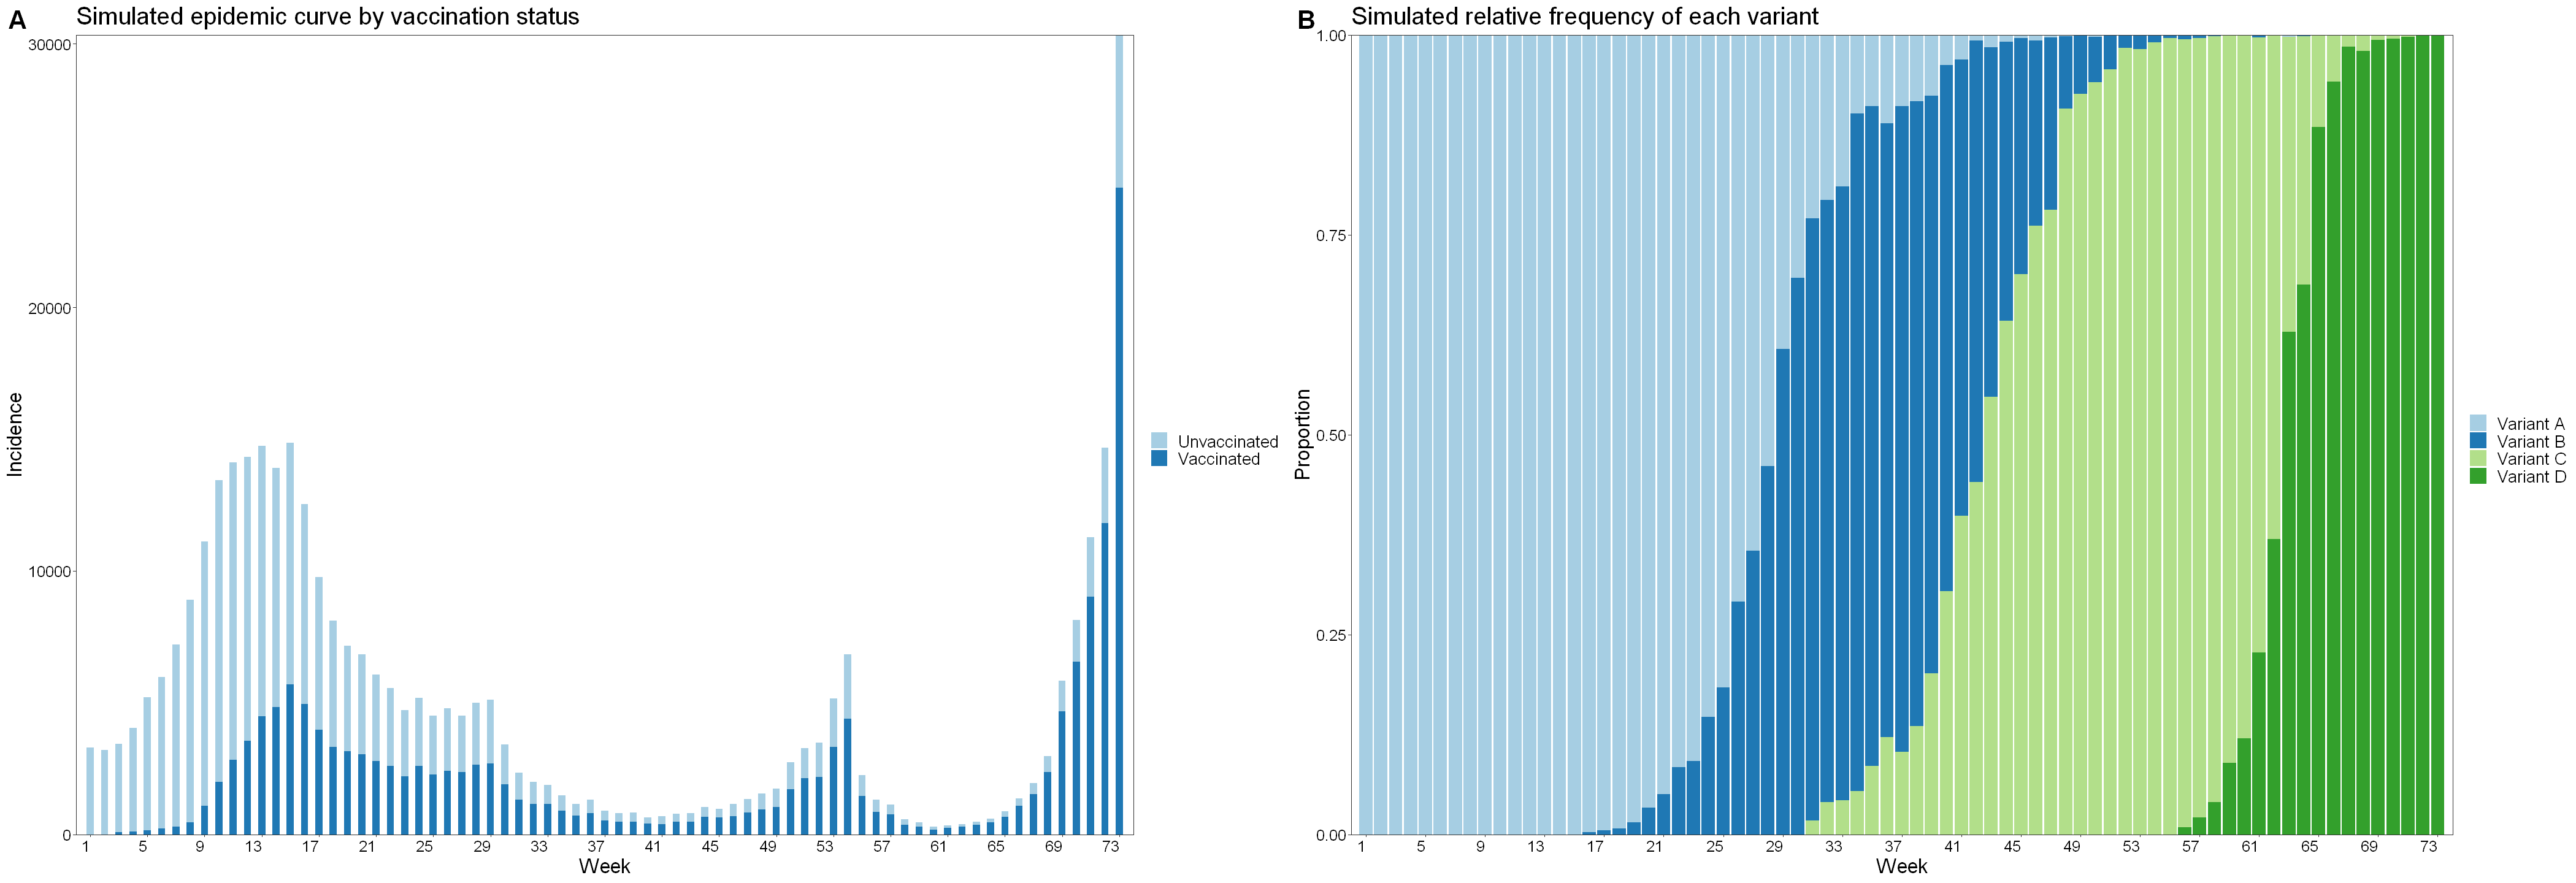

In [56]:
options(repr.plot.width=35,repr.plot.height=12)
ggarrange(case_simulation, voc_plot, nrow=1,ncol=2,font.label=list(size=25),labels=c("A","B"),legend="right")
ggsave(file = "output/simulation_data.pdf", width = 35, height = 12)

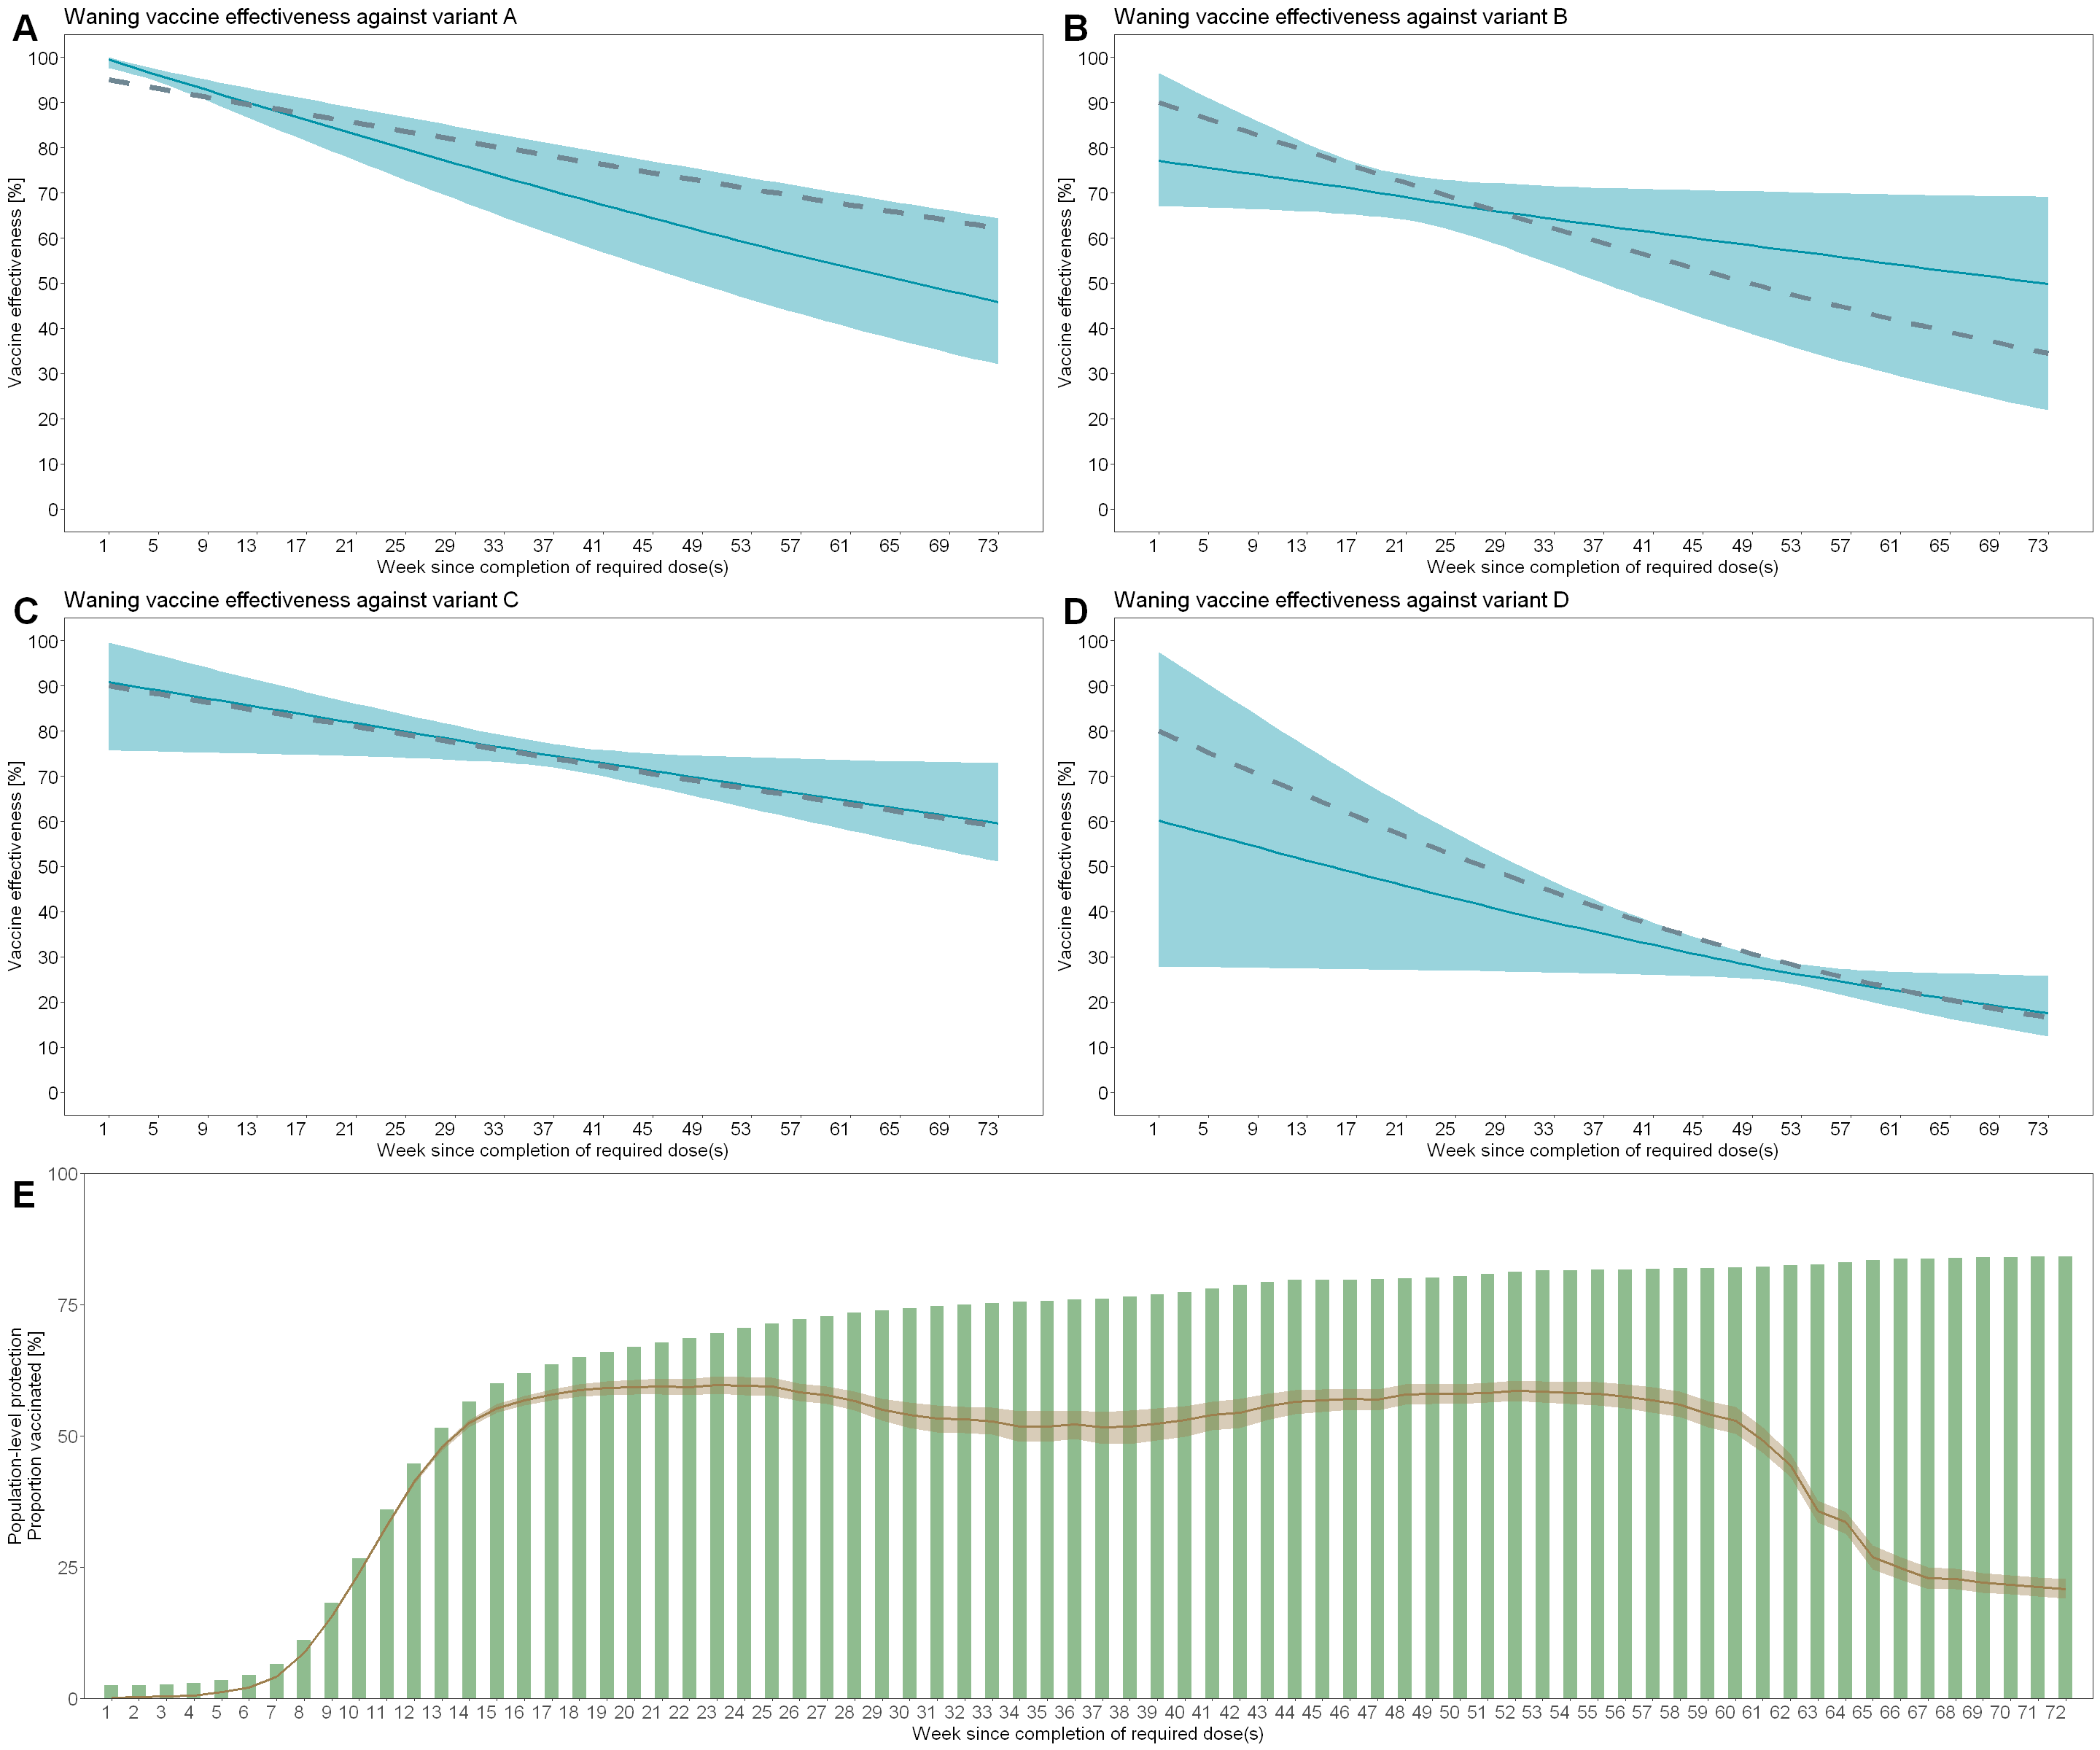

In [57]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"),legend="right")
ggsave(file = "output/VE_waning_simulation1_param.pdf", width = 24, height = 20)

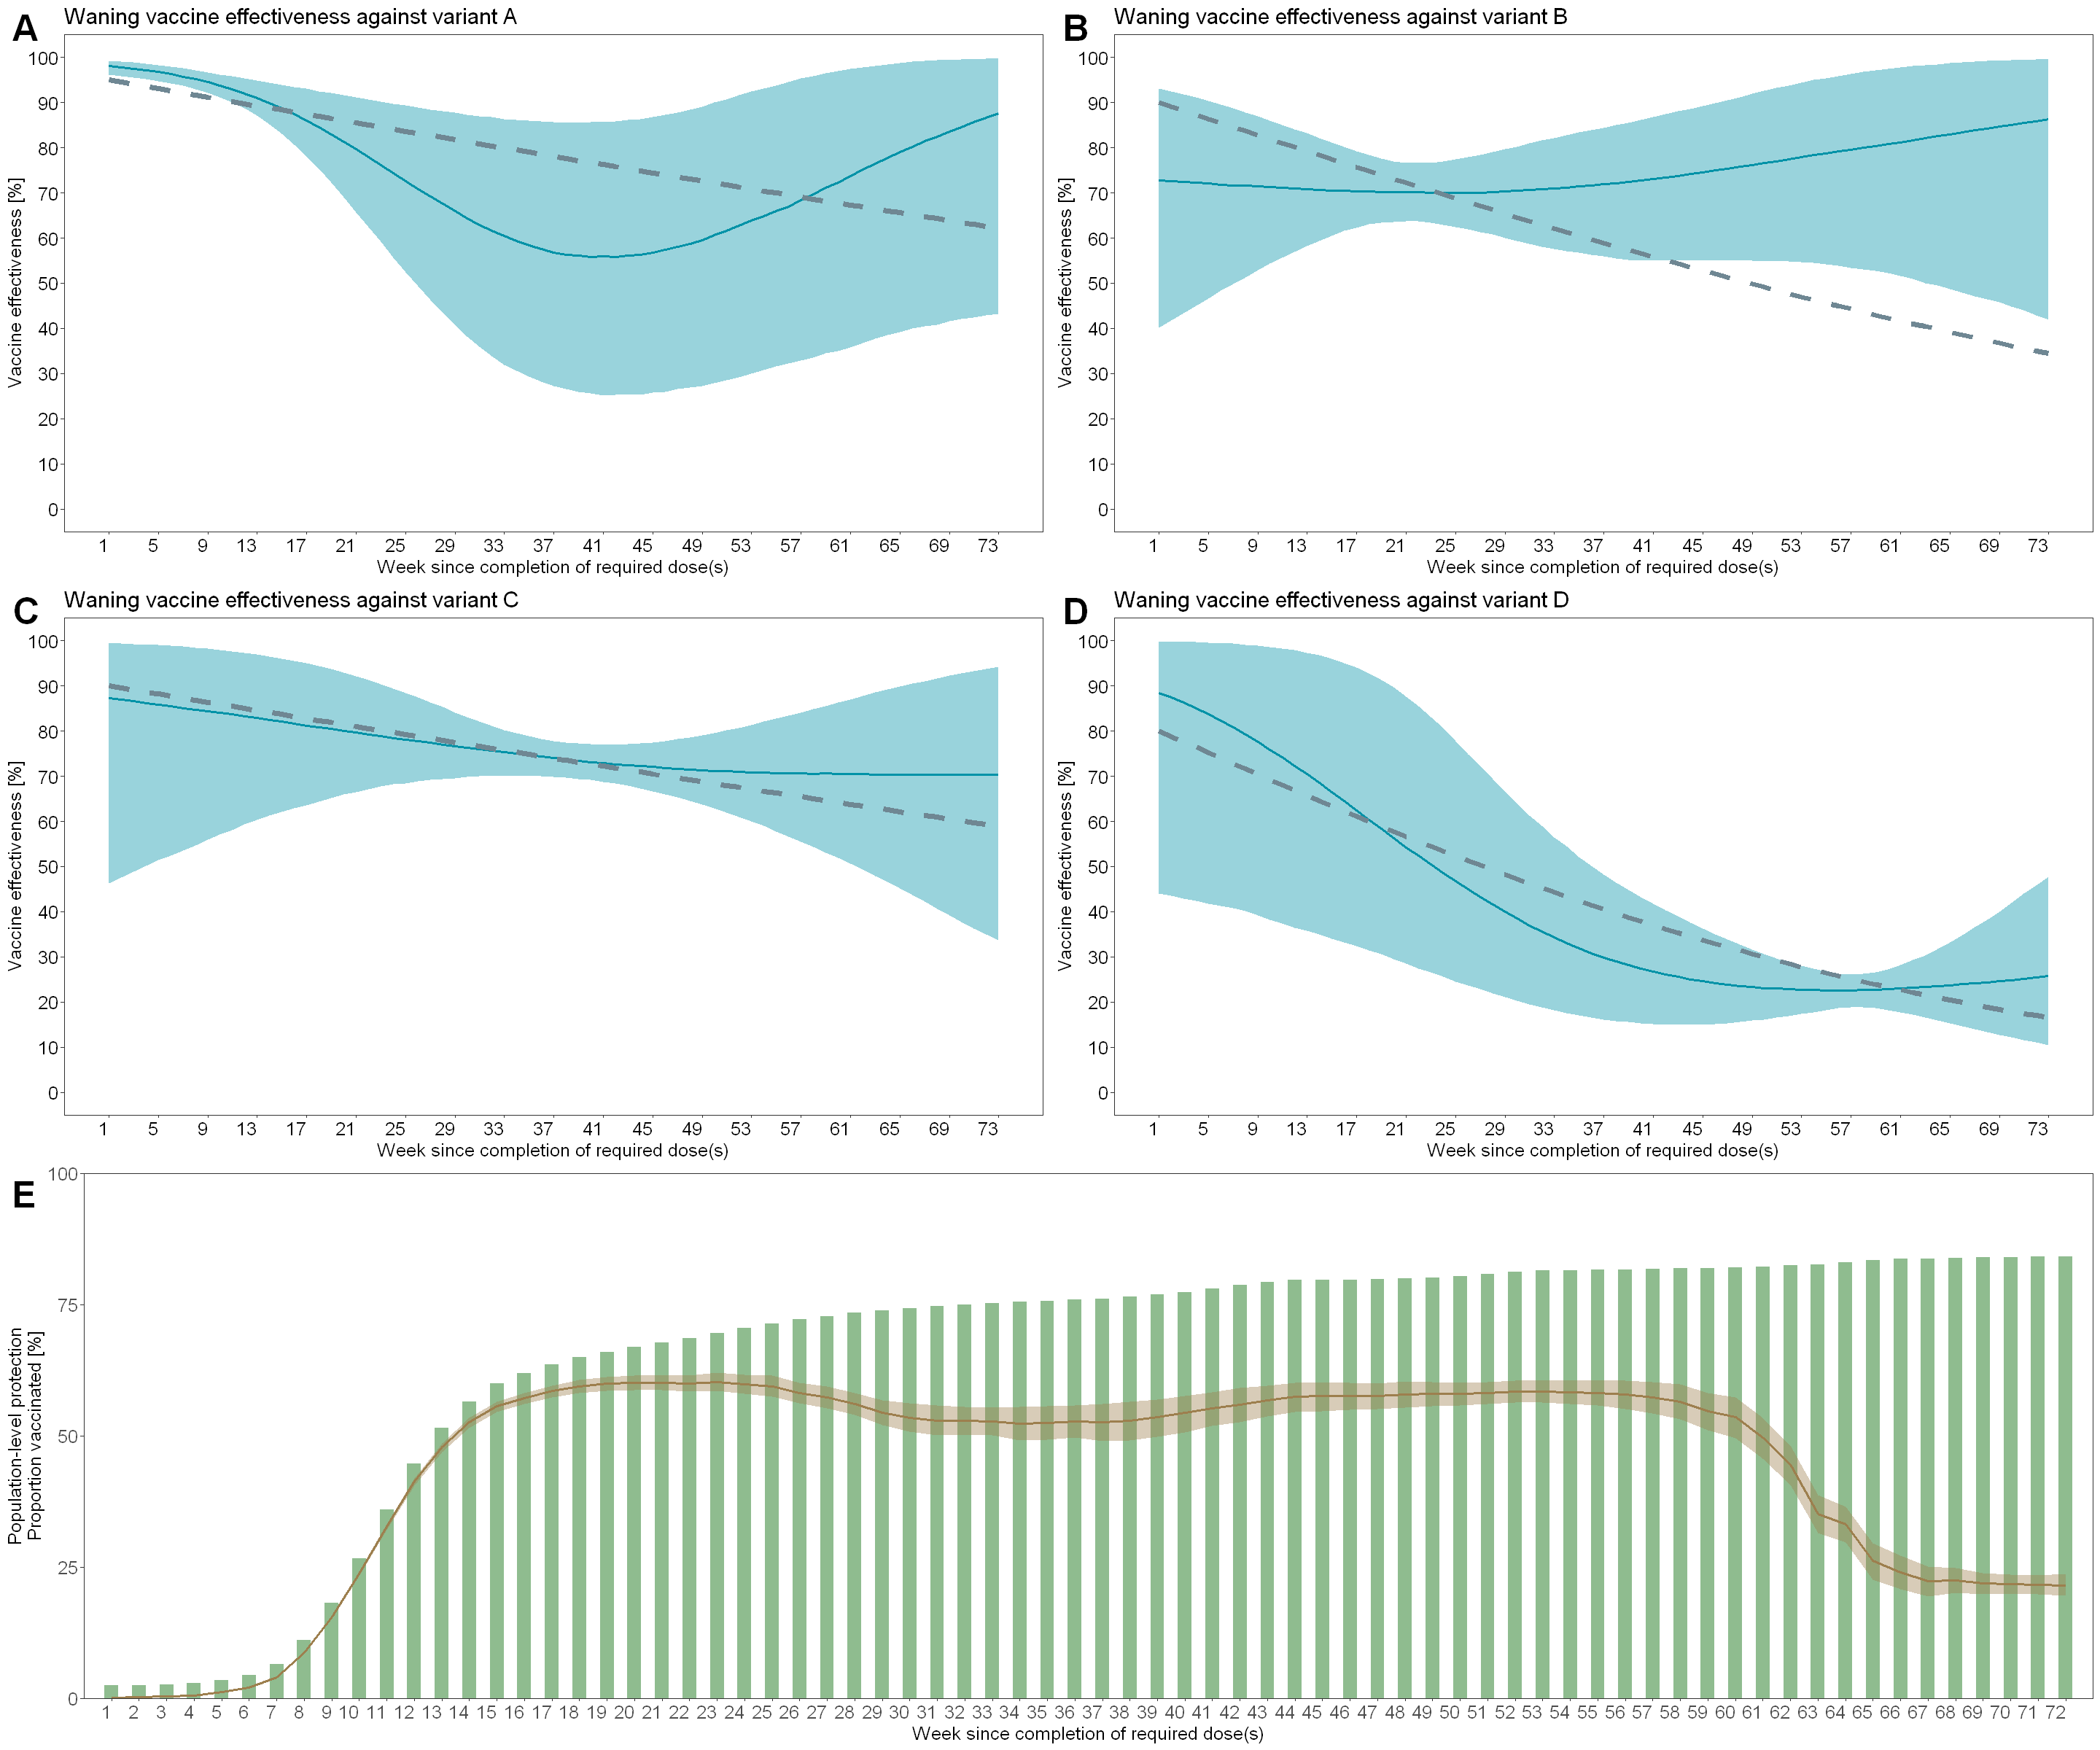

In [15]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"))

ggsave(file = "output/VE_waning_simulation1_spline.pdf", width = 24, height = 20)